# Exploration de données temporelles avec Matlab

Pierre Haessig & Marie-Anne Lefèbvre – octobre 2019

In [77]:
disp(version) % Matlab version: should be R2018b

9.5.0.1178774 (R2018b) Update 5


Configuration : affichage des graphiques "inline" (cf imatlab's [README](https://github.com/imatlab/imatlab#inline-graphics))

In [28]:
imatlab_export_fig('print-png')  % Static png figures.
%imatlab_export_fig('')  % Native windows.

## 1) Chargement & prétraitements des données

### Charger fichier de données avec `readtable`

Objectif : charger le fichier `data/meteo_rennes_2015.txt`

In [1]:
opts = detectImportOptions('data/meteo_rennes_2015.txt')


opts = 

  DelimitedTextImportOptions with properties:

   Format Properties:
                    Delimiter: {'\t'  ' '}
                   Whitespace: '\b'
                   LineEnding: {'\n'  '\r'  '\r\n'}
                 CommentStyle: {}
    ConsecutiveDelimitersRule: 'join'
        LeadingDelimitersRule: 'ignore'
                EmptyLineRule: 'skip'
                     Encoding: 'windows-1252'

   Replacement Properties:
                  MissingRule: 'fill'
              ImportErrorRule: 'fill'
             ExtraColumnsRule: 'addvars'

   Variable Import Properties: Set types by name using setvartype
                VariableNames: {'Var1', 'Var2', 'Var3' ... and 9 more}
                VariableTypes: {'double', 'double', 'double' ... and 9 more}
        SelectedVariableNames: {'Var1', 'Var2', 'Var3' ... and 9 more}
              VariableOptions: [1x12 matlab.io.NumericVariableImportOptions] 
	Access VariableOptions sub-properties using setvaropts/getvaropts

   Location Prope

[readtable](https://fr.mathworks.com/help/matlab/ref/readtable.html): Create table from file

In [2]:
meteo = readtable('data/meteo_rennes_2015.txt', opts);

[head](https://fr.mathworks.com/help/matlab/ref/head.html): Get top rows of table, timetable, or tall array

In [4]:
head(meteo, 3)


ans =

  3x12 table

    Var1    Var2    Var3    Var4    Var5    Var6    Var7     Var8    Var9    Var10    Var11    Var12
    ____    ____    ____    ____    ____    ____    _____    ____    ____    _____    _____    _____

    2015     1       1       0      -25     -35     10376    140      15       0      -9999        0
    2015     1       1       1      -30     -40     -9999    150      10       0      -9999    -9999
    2015     1       1       2      -30     -40     -9999    150      10       0      -9999    -9999



Cosmétique (facultatif) : renommage des noms des colonnes via les [table.Properties](https://fr.mathworks.com/help/matlab/ref/table.html#mw_cb8d6608-0cf9-4164-b1f8-7bce6caa23ce)

In [24]:
meteo.Properties.VariableNames(1) = {'Annee'};
meteo.Properties.VariableNames(2) = {'Mois'};
meteo.Properties.VariableNames(3) = {'Jour'};
meteo.Properties.VariableNames(4) = {'Heure'};
meteo.Properties.VariableNames(5) = {'Temp'};

Mise à l'échelle de la température (cf. documentation du jeu de données [data/ISD-Lite 2006 format.pdf](data/ISD-Lite%202006%20format.pdf))

In [9]:
meteo.Temp = meteo.Temp/10;

In [10]:
head(meteo, 3)


ans =

  3x12 table

    Annee    Mois    Jour    Heure    Temp    Var6    Var7     Var8    Var9    Var10    Var11    Var12
    _____    ____    ____    _____    ____    ____    _____    ____    ____    _____    _____    _____

    2015      1       1        0      -2.5    -35     10376    140      15       0      -9999        0
    2015      1       1        1        -3    -40     -9999    150      10       0      -9999    -9999
    2015      1       1        2        -3    -40     -9999    150      10       0      -9999    -9999



Copie dans une variable dédiée

In [25]:
Temp = meteo.Temp;
Temp(1:3)


ans =

   -2.5000
   -3.0000
   -3.0000



Remarque : `Temp` est matrice (array) "classique" de Matlab

In [23]:
class(Temp)


ans =

    'double'



### Données manquantes ou aberrantes

Température moyenne : il fait froid à Rennes !

In [26]:
mean(Temp)


ans =

    0.0876



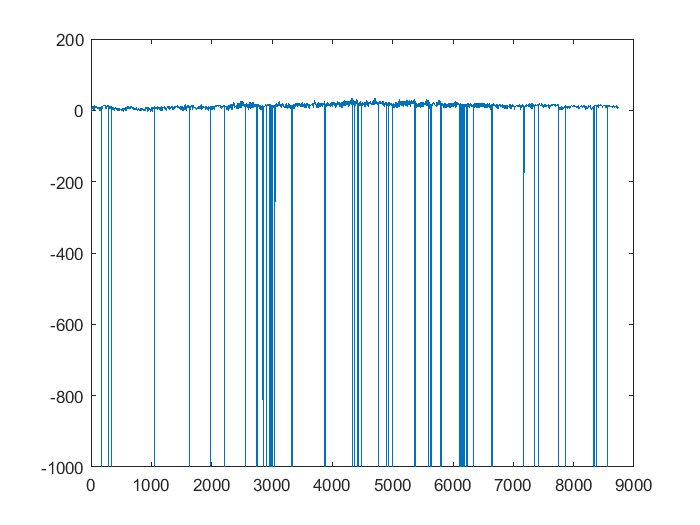

In [29]:
plot(Temp)

In [30]:
min(Temp)


ans =

 -999.9000



Le problème : les données manquantes sont notées -9999 dans le fichier (cf. documentation du jeu de données [data/ISD-Lite 2006 format.pdf](data/ISD-Lite%202006%20format.pdf)). La mise à l'échelle a transformée cette valeur en -999.9

Solution : marquer ces valeurs comme manquante

* Doc : [Missing Data in MATLAB](https://fr.mathworks.com/help/matlab/data_analysis/missing-data-in-matlab.html)
* fonction [missing](https://fr.mathworks.com/help/matlab/ref/missing.html): Create missing values

Pour cela, on peut se servir du [logical indexing](https://blogs.mathworks.com/steve/2008/01/28/logical-indexing/) (syntaxe très utile en Matlab, mais aussi avec les tableau numpy en Python)

In [33]:
Temp_bad = Temp == -999.9;  %crée en logical array
Temp_bad(1:3)


ans =

  3x1 logical array

   0
   0
   0



Combien y a-t-il de valeurs absurdes? → Somme du vecteur logique :

In [34]:
sum(Temp_bad)


ans =

   105



In [36]:
Temp(Temp_bad) = missing;

Mais il y a aussi des données non enregistrées

cf. https://fr.mathworks.com/help/matlab/ref/height.html

In [37]:
365*24 - height(meteo)


ans =

    21



Attention, les changements de la variable `Temp` ne sont pas reproduits dans `meteo.Temp`, car c'est une copie. Il faut donc faire la copie dans l'autre sens

In [61]:
meteo.Temp = Temp;

A présent, le tracé de la température a bonne allure, mais...

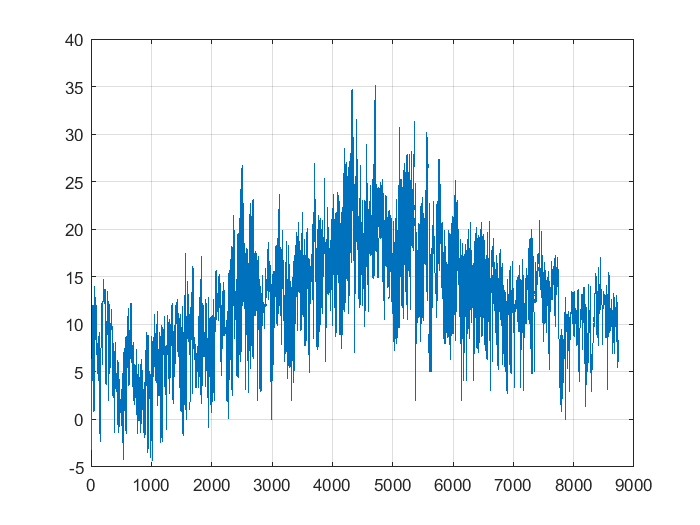

In [40]:
plot(Temp)
grid on;

... mais attention, les NaNs *ne sont pas détectables* sur le graphique, même s'ils sont bien présents. Exemple avec un zoom autour de l'indice 2200. 

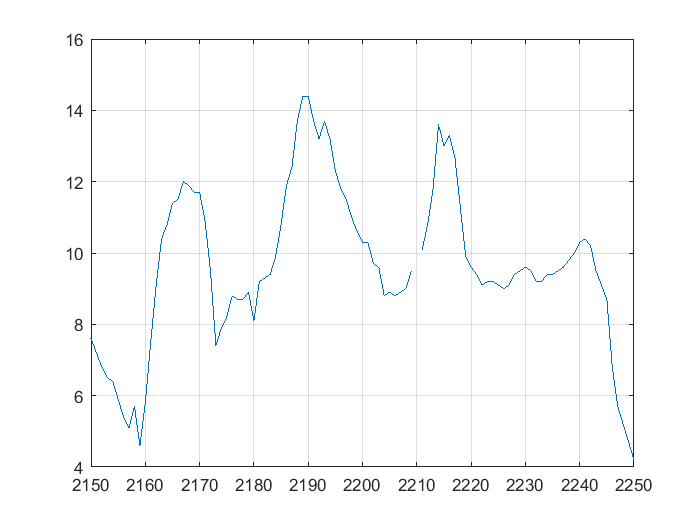

In [45]:
plot(Temp)
xlim([2150 2250])
grid on;

Calcul de la moyenne : attention à la propagation des NaNs:

In [42]:
mean(Temp)


ans =

   NaN



Doc [Data with Missing Values](https://fr.mathworks.com/help/stats/data-with-missing-values.html)

In [43]:
nanmean(Temp)


ans =

   12.2487



Pour voir la répartition des données : histogramme 

cf. [histogram](https://fr.mathworks.com/help/matlab/ref/matlab.graphics.chart.primitive.histogram.html)

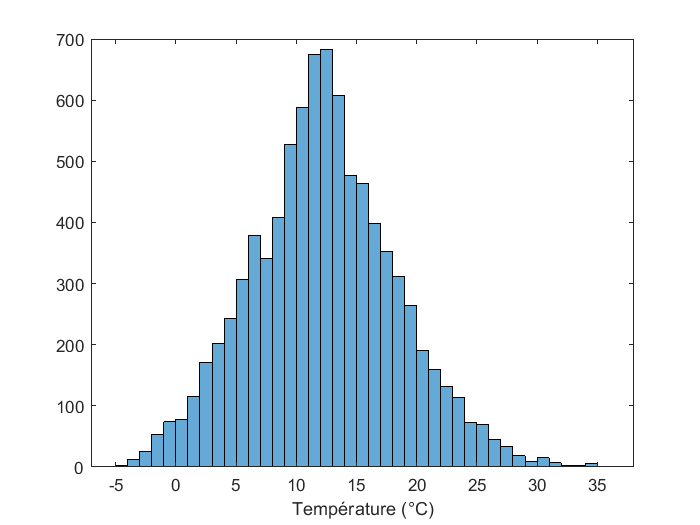

In [70]:
histogram(Temp)
xlabel('Température (°C)')

### Dates : parsing (décodage) et représentation

Fonction constructeur [datetime](https://fr.mathworks.com/help/matlab/ref/datetime.html): Arrays that represent points in time

In [51]:
meteo_date = datetime(meteo.Annee, meteo.Mois, meteo.Jour,...
                      meteo.Heure, 0,0);
meteo_date(1:3)


ans = 

  3x1 datetime array

   01-Jan-2015 00:00:00
   01-Jan-2015 01:00:00
   01-Jan-2015 02:00:00



In [49]:
disp(class(meteo_date))

datetime


Conversion table → timetable

Une fois la date décodée, le conteneur `table` peut être converti en `timetable` qui facilite le traitement des données horodatées. 
*(introduced in R2016b)*.

cf [Timetables](https://fr.mathworks.com/help/matlab/timetables.html) doc

In [62]:
meteo_TT = table2timetable(meteo, 'RowTimes', meteo_date);
head(meteo_TT, 3)


ans =

  3x12 timetable

            Time            Annee    Mois    Jour    Heure    Temp    Var6    Var7     Var8    Var9    Var10    Var11    Var12
    ____________________    _____    ____    ____    _____    ____    ____    _____    ____    ____    _____    _____    _____

    01-Jan-2015 00:00:00    2015      1       1        0      -2.5    -35     10376    140      15       0      -9999        0
    01-Jan-2015 01:00:00    2015      1       1        1        -3    -40     -9999    150      10       0      -9999    -9999
    01-Jan-2015 02:00:00    2015      1       1        2        -3    -40     -9999    150      10       0      -9999    -9999



**sélectionner un intervalle de temps**. Exemple : mois de juin 

méthode 1 (plus générique) avec une indexation par un [timerange](https://fr.mathworks.com/help/matlab/ref/timerange.html)

In [67]:
TR = timerange('2015-06-01','2015-07-01');
meteo_juin = meteo_TT(TR, :);
disp(nanmean(meteo_juin.Temp))

   17.1027



méthode 2 (plus spécifique) : avec logical indexing

In [66]:
meteo_juin2 = meteo(meteo_date.Month==6, :);
disp(nanmean(meteo_juin2.Temp))

   17.1027



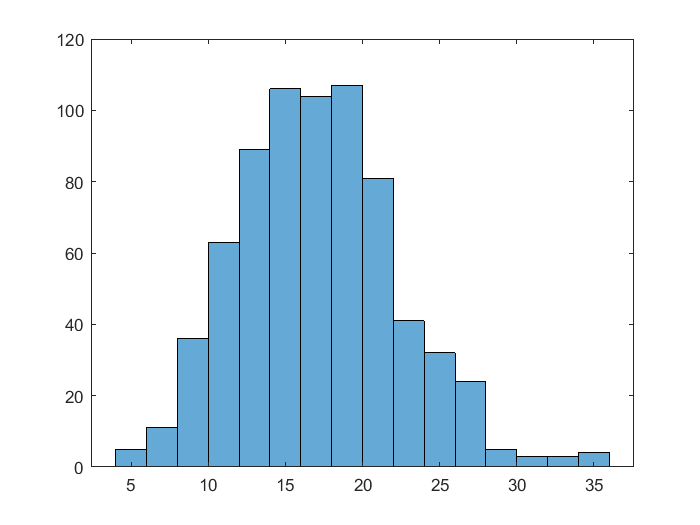

In [71]:
histogram(meteo_juin2.Temp)

Pour une comparaison rapide de la distribution *pour chaque mois* : boxplot, en utilisant la variable Mois pour le regroupement

https://fr.mathworks.com/help/stats/grouping-variables.html

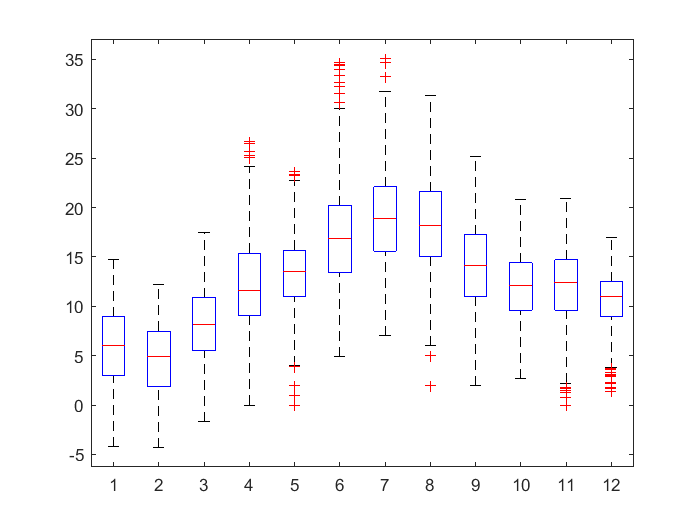

In [74]:
boxplot(meteo.Temp, meteo.Mois )
% TODO: remplacer le xticklabels numérique par le nom des mois
% xticklabels({'Jan',  'Fév','Mar', '...'})

## 2) Mise en forme & synchronisation de données

Fichiers : log capteur de qualité de l’air salle 404 (et archive météo)

Aperçu de `log-20150309-171821.csv` :
```
date;time;type;value;unit
09/03/2015;17:18:29.244;carbon dioxide;1630;ppm
09/03/2015;17:19:12.416;indoor relative humidity;37.0;%
09/03/2015;17:20:12.689;indoor relative humidity;37.0;%
```

In [75]:
%% Données capteur qualité de l'air
log = readtable('./data/log-20150309-171821.csv');
head(log, 3)


ans =

  3x5 table

       date           time                   type               value    unit 
    __________    ____________    __________________________    _____    _____

    09/03/2015    17:18:29.244    'carbon dioxide'              1630     'ppm'
    09/03/2015    17:19:12.416    'indoor relative humidity'      37     '%'  
    09/03/2015    17:20:12.689    'indoor relative humidity'      37     '%'  



Observation sur les dates :
* la colonne `date` est bien parsée en `datetime`
* la colonne `time` est bien parsée en `duration` (https://fr.mathworks.com/help/matlab/ref/duration.html)

In [80]:
disp(class(log.date)) % datetime

datetime


In [81]:
disp(class(log.time)) % cell of string: pb!!

duration


Cependant, dans Matlab R2017b, colonne `time` n'était pas parsée. Il fallait faire le décodage à la main:

In [ ]:
% log_time = datetime(log.time, 'InputFormat', 'HH:mm:ss.SSS');
% log_time = timeofday(log_time); % datetime → duration

Combinaison de la date et de l'heure : addition. Cependant, l'affichage est *trompeur*

In [89]:
log_datetime = log.date + log.time;
disp(log_datetime(1:3))

   09/03/2015
   09/03/2015
   09/03/2015



**À lire absolument** : [datetime.Format](https://fr.mathworks.com/help/matlab/ref/datetime.html#buhzxmk-1-Format)

In [90]:
log_datetime.Format


ans =

    'dd/MM/uuuu'



In [93]:
%log_datetime.Format = 'default';
log_datetime.Format = 'yyyy-MM-dd HH:mm:ss.SSS';
disp(log_datetime(1:3))

   2015-03-09 17:18:29.244
   2015-03-09 17:19:12.416
   2015-03-09 17:20:12.689



In [94]:
log_TT = table2timetable(log, 'RowTimes', log_datetime);
head(log_TT, 3)


ans =

  3x5 timetable

             Time                 date           time                   type               value    unit 
    _______________________    __________    ____________    __________________________    _____    _____

    2015-03-09 17:18:29.244    09/03/2015    17:18:29.244    'carbon dioxide'              1630     'ppm'
    2015-03-09 17:19:12.416    09/03/2015    17:19:12.416    'indoor relative humidity'      37     '%'  
    2015-03-09 17:20:12.689    09/03/2015    17:20:12.689    'indoor relative humidity'      37     '%'  



De façon générale, le datetime Format est la seule solution pour parser des dates suffisamment bizarres pour que Matlab ne détecte pas le format tout seul. Exemple :

In [122]:
dates_bizarres = {'01/09/2019 à 01h25' '01/10/2019 à 02h45'};
datetime(dates_bizarres)

Error using datetime (line 635)
Could not recognize the format of the date/time text. You can specify a format using the 'InputFormat' parameter. If the date/time text contain day, month, or time zone names in a language foreign to the 'en_US' locale, those might not be recognized. You can specify a different locale using the 'Locale' parameter.


In [123]:
datetime(dates_bizarres, 'InputFormat', 'dd/MM/yyyy à HH''h''mm' )


ans = 

  1x2 datetime array

   01-Sep-2019 01:25:00   01-Oct-2019 02:45:00



### Variable categorielle

In [95]:
class(log.type)


ans =

    'cell'



In [99]:
class(log.type{1})


ans =

    'char'



Colonne `type` : 118 008 chaines de caractères, pesant 18 Mo

In [102]:
type = log.type;
whos type

  Name           Size               Bytes  Class    Attributes

  type      118008x1             18202288  cell               



La conversion en [categorical](https://fr.mathworks.com/help/matlab/ref/categorical.html) ramène le poids à peine plus de 118 ko (~1 octet par élément)

In [103]:
type = categorical(type);
whos type

  Name           Size             Bytes  Class          Attributes

  type      118008x1             118916  categorical              



Observer la disparition des `'` dans la colonne `type`

In [104]:
log.type = type;
head(log, 3)


ans =

  3x5 table

       date           time                  type              value    unit 
    __________    ____________    ________________________    _____    _____

    09/03/2015    17:18:29.244    carbon dioxide              1630     'ppm'
    09/03/2015    17:19:12.416    indoor relative humidity      37     '%'  
    09/03/2015    17:20:12.689    indoor relative humidity      37     '%'  



### Empilement/désempilement

Les données sont dans un format dit "long" ([vs "narrow"](https://en.wikipedia.org/wiki/Wide_and_narrow_data)) aussi appelé "empilé" (EN : "stacked").

Pour récupére un seul type de mesure, le logical indexing est suffisant

In [107]:
a = type == 'indoor temperature';
disp(mean(a)) % proportion de mesures de ce type parmi toutes les mesures

    0.1492



In [109]:
unique(log.type) % all the existing channel names


ans = 

  6x1 categorical array

     carbon dioxide 
     indoor relative humidity 
     indoor temperature 
     outdoor temperature 
     solar Irradiance 
     volatile organic compounds 



In [132]:
Temp = log_TT(type == 'indoor temperature', 'value'); %si on veut plusieurs colonnes, utiliser un cell-array {'type', 'value'}
Text_DD = log_TT(type == 'outdoor temperature', 'value');
CO2 = log_TT(type == 'carbon dioxide', 'value');

head(Temp, 3)


ans =

  3x1 timetable

             Time              value
    _______________________    _____

    2015-03-09 17:21:02.496    23.4 
    2015-03-09 17:24:03.886    23.3 
    2015-03-09 17:27:03.094    23.3 



In [133]:
% Rename 'value' to the corresponding value type
Temp.Properties.VariableNames = {'Temp'};
Text_DD.Properties.VariableNames = {'Text_DD'};
CO2.Properties.VariableNames = {'CO2'};

head(Temp, 3)


ans =

  3x1 timetable

             Time              Temp
    _______________________    ____

    2015-03-09 17:21:02.496    23.4
    2015-03-09 17:24:03.886    23.3
    2015-03-09 17:27:03.094    23.3



Désempilement automatique: [unstack](https://fr.mathworks.com/help/matlab/ref/unstack.html)

In [166]:
a = unstack(log_TT, 'value', 'type'); % a est plein de NaNs
head(a, 3)


ans =

  3x6 timetable

             Time              carbonDioxide    indoorRelativeHumidity    indoorTemperature    outdoorTemperature    solarIrradiance    volatileOrganicCompounds
    _______________________    _____________    ______________________    _________________    __________________    _______________    ________________________

    2015-03-09 17:18:29.244        1630                  NaN                     NaN                  NaN                  NaN                    NaN           
    2015-03-09 17:19:12.416         NaN                   37                     NaN                  NaN                  NaN                    NaN           
    2015-03-09 17:20:12.689         NaN                   37                     NaN                  NaN                  NaN                    NaN           



Régularité de l'échantillonage : non

In [191]:
disp(isregular(log_TT))

   0



### Rééchantillonnage et agrégation

https://fr.mathworks.com/help/matlab/ref/timetable.retime.html

Pour un rééchantillonage 'daily', 'hourly', 'minutely'... :

```
TT2 = retime(TT1,newTimeStep)
TT2 = retime(TT1,newTimeStep,method)
```

Pour pouvoir spécifier le pas de temps de façon plus fine ([R2018a](https://fr.mathworks.com/help/matlab/release-notes.html?category=data-analysis&rntext=retime&startrelease=R2018a&endrelease=R2018a&groupby=release&sortby=descending&searchHighlight=retime))

```
TT2 = retime(TT1,'regular',method,'TimeStep',dt)
TT2 = retime(TT1,'regular','TimeStep',dt)
```

In [167]:
log_1m = retime(a, 'minutely', 'previous');
head(log_1m,5);

In [175]:
log_3m = retime(a, 'regular', 'previous', 'TimeStep', minutes(3));

In [174]:
log_1m(1:10, 1:3)


ans =

  10x3 timetable

             Time              carbonDioxide    indoorRelativeHumidity    indoorTemperature
    _______________________    _____________    ______________________    _________________

    2015-03-09 17:18:00.000         NaN                  NaN                     NaN       
    2015-03-09 17:19:00.000        1630                  NaN                     NaN       
    2015-03-09 17:20:00.000        1630                   37                     NaN       
    2015-03-09 17:21:00.000        1630                   36                     NaN       
    2015-03-09 17:22:00.000        1630                   36                    23.4       
    2015-03-09 17:23:00.000        1630                   36                    23.4       
    2015-03-09 17:24:00.000        1630                   36                    23.4       
    2015-03-09 17:25:00.000        1630                   36                    23.3       
    2015-03-09 17:26:00.000        1630              

In [176]:
log_3m(1:4, 1:3)


ans =

  4x3 timetable

             Time              carbonDioxide    indoorRelativeHumidity    indoorTemperature
    _______________________    _____________    ______________________    _________________

    2015-03-09 17:18:00.000         NaN                  NaN                     NaN       
    2015-03-09 17:21:00.000        1630                   36                     NaN       
    2015-03-09 17:24:00.000        1630                   36                    23.4       
    2015-03-09 17:27:00.000        1630                   36                    23.3       



In [190]:
disp(isregular(log_3m))

   1



### Statistiques par groupes (bonus)

cf.

* doc [Summary Statistics Grouped by Category](https://fr.mathworks.com/help/stats/summary-statistics-grouped-by-category.html) (Warning: makes use of data in the deprecated `dataset array` type)
* 
https://fr.mathworks.com/help/stats/grpstats.html

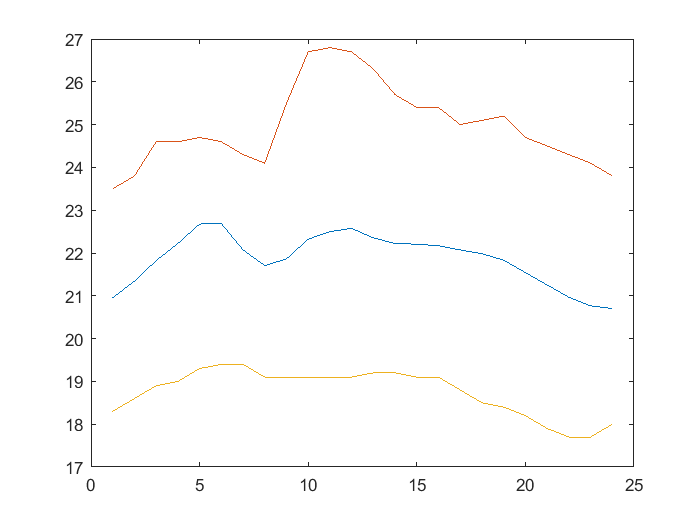

In [163]:
[Temp_by_hour_avg, Temp_by_hour_max, Temp_by_hour_min]  = grpstats(Temp.Temp, Temp.Time.Hour, {'mean', 'max', 'min'});
plot(Temp_by_hour_avg)
hold on
plot(Temp_by_hour_max)
plot(Temp_by_hour_min)

La resynchro permet de faire des nuages de points par exemple (et puis ensuite des régressions et autre analyses)

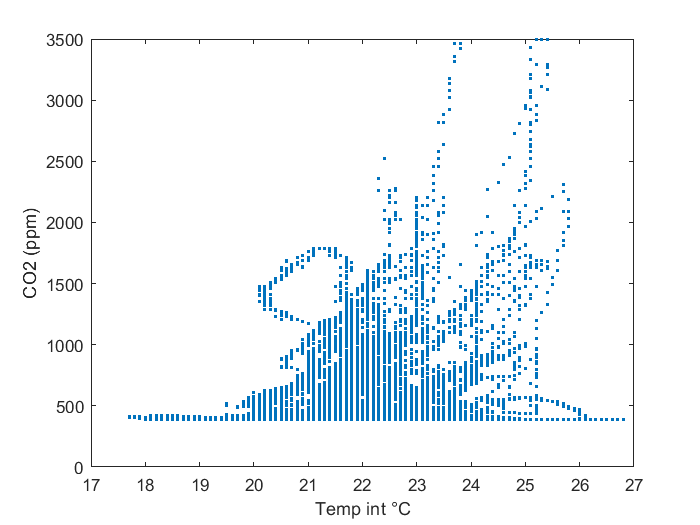

In [184]:
plot(log_3m.indoorTemperature, log_3m.carbonDioxide, '.')
xlabel('Temp int °C')
ylabel('CO2 (ppm)')

### Choix de la méthode de rééchantillonnage.

Tracer un nuage de point de la température extérieure (issue du capteur de la salle 404) vs la température à Rennes de l’archive météo.

In [185]:
%...

## 3) Recap final

Fichiers : fiche de présence salle 404 (et log qualité de l’air, archive météo)